# Time Series Forecasting using LSTM


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Read csv data

In [4]:
time_df = pd.read_csv('timeseries.csv', header=None, usecols=[0,1], names=["TS1","TS2"])

In [5]:
time_df.head()

,TS1,TS2
0,71.1,66.0
1,68.1,66.8
2,68.0,64.3
3,68.3,67.8
4,68.9,69.5


In [6]:
len(time_df['TS1'])

12672

In [7]:
len(time_df['TS2'])

12672

### Visualize time series data

In [8]:
def visualize_timeSeries(df,ts,color):
    plt.figure(figsize=(20,6))
    plt.title('Time Series Data')
    plt.grid(True)
    plt.autoscale(axis='x')
    plt.plot(df, color=color, label=f'Time Series - {ts}')
    plt.legend()
    plt.show()

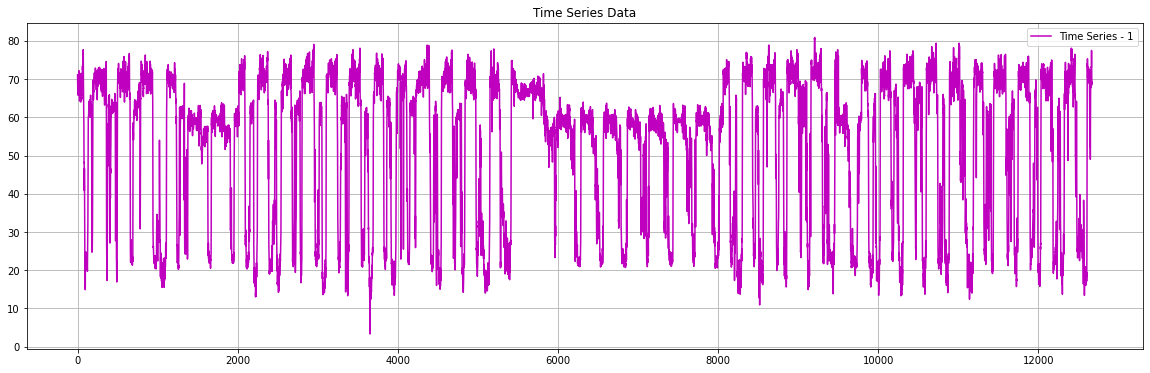

In [9]:
visualize_timeSeries(time_df['TS1'], 1, 'm')

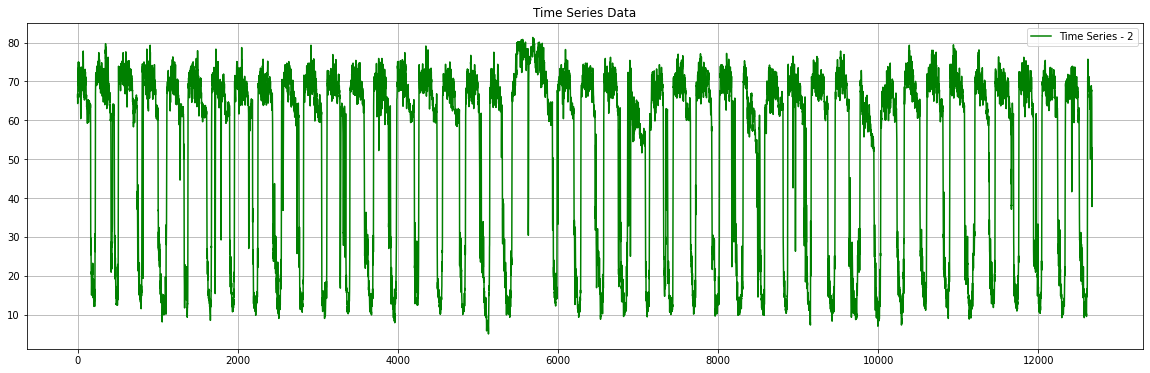

In [10]:
visualize_timeSeries(time_df['TS2'], 2, 'g')

### Plot the time series statistics

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, plotTitle):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')    
    plt.legend(loc='best')
    plt.title(f'Rolling Mean & Standard Deviation for {plotTitle}')
    plt.show()

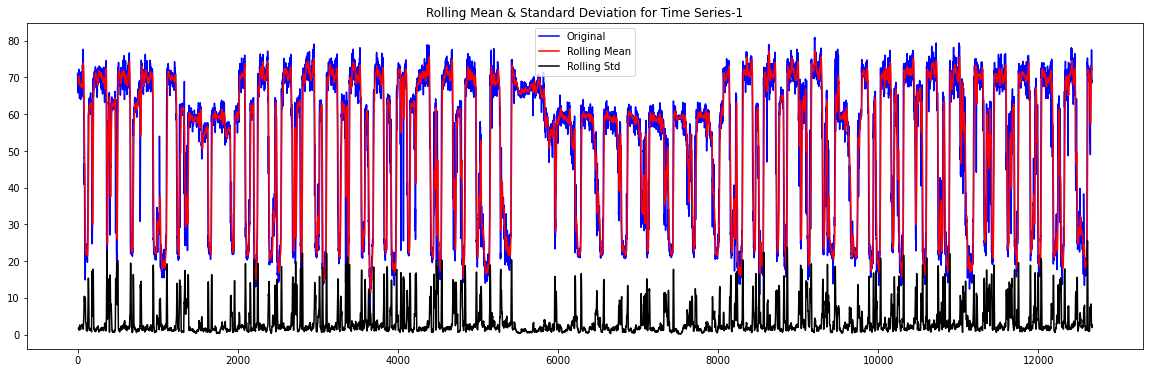

In [12]:
test_stationarity(time_df['TS1'], "Time Series-1")

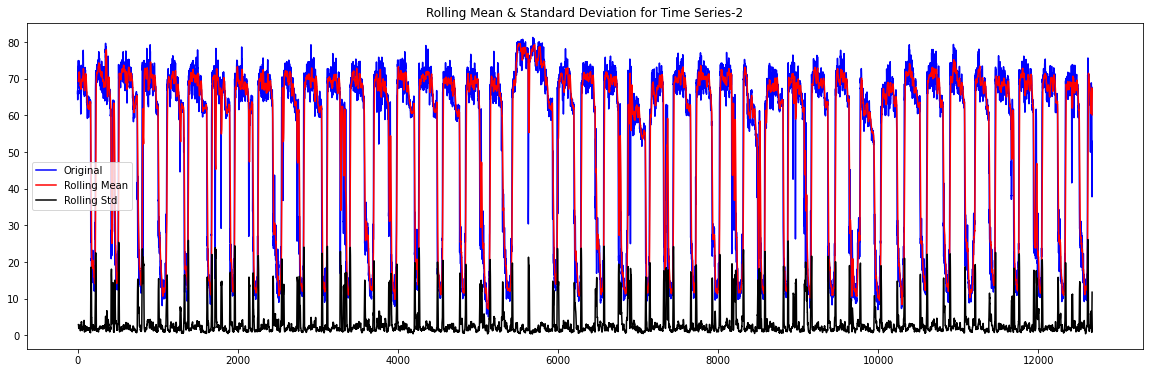

In [13]:
test_stationarity(time_df['TS2'], "Time Series-2")

### Data Preparation

In [14]:
#Define test and validation set size
test_size = 1440
val_size = 1440

#Divide data into train, validation and test for time series 1 and 2.
def prepare_data(ts_df):
    ts = ts_df.values.astype(float)
    train_set = ts[:-(val_size+test_size)]
    val_set = ts[-(val_size+test_size) : -test_size ]
    test_set = ts[-test_size:]
    
    return train_set, val_set, test_set

In [15]:
train_TS1, val_TS1, test_TS1 = prepare_data(time_df['TS1'])

In [16]:
train_TS2, val_TS2, test_TS2 = prepare_data(time_df['TS2'])

### Normalize the data

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [18]:
# Normalize the training, validation and test set

def normalize_data(train_set, val_set, test_set):
    train_norm = scaler.fit_transform(train_set.reshape(-1, 1))
    val_norm = scaler.transform(val_set.reshape(-1, 1))
    test_norm = scaler.transform(test_set.reshape(-1, 1))
    
    return train_norm, val_norm, test_norm

In [19]:
train_norm_TS1, val_norm_TS1, test_norm_TS1 = normalize_data(train_TS1, val_TS1, test_TS1)
train_norm_TS2, val_norm_TS2, test_norm_TS2 = normalize_data(train_TS2, val_TS2, test_TS2)

### Prepare Data for DataLoaders

In [20]:
# Define a window size
window_size = 12

class TimeSeriesDataset(Dataset):
    def __init__(self, data, label):
        self.data = data       
        self.label = label
 
    def __getitem__(self, i):
        x = self.data[i]
        y = self.label[i]
        return x, y
 
    def __len__(self):
        return len(self.data) -  window_size

In [21]:
# Define function to create seq/label tuples
def input_data(seq):  
    
    # Convert sequence from an array to a tensor
    seq = torch.FloatTensor(seq).view(-1)
    
    out = []
    x_data = []
    y_data = []
    L = len(seq)
    for i in range(L-window_size):        
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        x_data.append(window)
        y_data.append(label)
    return x_data, y_data

In [22]:
#Prepare training, validation and test data for both tome series 1 and 1.

#Timeseries - 1
X_train_TS1, y_train_TS1 = input_data(train_norm_TS1)
X_val_TS1, y_val_TS1 = input_data(val_norm_TS1)
X_test_TS1, y_test_TS1 = input_data(test_norm_TS1)

#Timeseries - 2
X_train_TS2, y_train_TS2 = input_data(train_norm_TS2)
X_val_TS2, y_val_TS2 = input_data(val_norm_TS2)
X_test_TS2, y_test_TS2 = input_data(test_norm_TS2)

In [23]:
#Prepare Dataset for both TimeSeries
train_ds_TS1 = TimeSeriesDataset(X_train_TS1, y_train_TS1)
val_ds_TS1 = TimeSeriesDataset(X_val_TS1, y_val_TS1)
test_ds_TS1 = TimeSeriesDataset(X_test_TS1, y_test_TS1)

train_ds_TS2 = TimeSeriesDataset(X_train_TS2, y_train_TS2)
val_ds_TS2 = TimeSeriesDataset(X_val_TS2, y_val_TS2)
test_ds_TS2 = TimeSeriesDataset(X_test_TS2, y_test_TS2)

### Define DataLoaders

In [28]:
batch_size = 10

In [29]:
def load_data(train_ds, val_ds, test_ds):
    train_loader = DataLoader(train_ds, batch_size=batch_size,drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size,drop_last=True)
    test_loader = DataLoader(test_ds,batch_size=1)
    
    return train_loader, val_loader, test_loader

In [30]:
train_loader_TS1, val_loader_TS1, test_loader_TS1 = load_data(train_ds_TS1, val_ds_TS1, test_ds_TS1)
train_loader_TS2, val_loader_TS2, test_loader_TS2 = load_data(train_ds_TS2, val_ds_TS2, test_ds_TS2)

In [31]:
train_on_gpu=torch.cuda.is_available()
train_on_gpu

False

In [32]:
train_on_gpu

False

### Create a LSTM model

In [33]:
class TimeSeriesLSTM(nn.Module):
    def __init__(self,input_size=1,hidden_size=28,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        

    def forward(self, seq, hidden):
        
        batch_size =  seq.shape[0] 
        seq_len = window_size
        
        lstm_out, hidden = self.lstm(
            seq.view(seq_len,batch_size,1), hidden)
        pred = self.linear(lstm_out.view(seq_len,batch_size,-1))
        return pred[-1]  # fetch only the last value in prediction
    
    
    def hidden_state(self, batch_size):
        
        if train_on_gpu:
            
            hidden = (torch.zeros(1,batch_size,self.hidden_size).cuda(),
                     torch.zeros(1,batch_size,self.hidden_size).cuda())
        else:
            hidden = (torch.zeros(1,batch_size,self.hidden_size),
                     torch.zeros(1,batch_size,self.hidden_size))

        return hidden

### RMSE loss 

In [123]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

### Instantiate Model

In [35]:
torch.manual_seed(322)
model = TimeSeriesLSTM()

criterion = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model

TimeSeriesLSTM(
  (lstm): LSTM(1, 28)
  (linear): Linear(in_features=28, out_features=1, bias=True)
)

### Train the model

In [36]:
epochs = 60

In [37]:
def train_one_epoch(train_loader):
    model.train()
    for idx, (inputs, targets) in enumerate(train_loader):
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        hidden = model.hidden_state(batch_size)
        inputs, targets = inputs.to(device), targets.to(device)
        y_pred = model(inputs,hidden)
        
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        
    return loss.item()

In [38]:
def validate(val_loader):
    model.eval()
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(val_loader):

            # reset the parameters and hidden states           
            hidden = model.hidden_state(batch_size)
            inputs, targets = inputs.to(device), targets.to(device)
            y_pred = model(inputs,hidden)            

            loss = criterion(y_pred, targets)
        
    return loss.item()

In [39]:
#Train time series 1
print("Training for TS1")
for epoch in range(epochs):
    
    train_loss = train_one_epoch(train_loader_TS1)
    val_loss = validate(val_loader_TS1)
    message = (f"epoch:{epoch+1}   train_loss:{train_loss:10.8f}    "
              f"val_loss:{val_loss:10.8f}")
    
    if epoch%10 == 0:
        print(message)

Training for TS1
epoch:1   train_loss:0.06903598    val_loss:0.08957061
epoch:11   train_loss:0.09345209    val_loss:0.03074850
epoch:21   train_loss:0.08237043    val_loss:0.02548206
epoch:31   train_loss:0.06545208    val_loss:0.02847332
epoch:41   train_loss:0.05770960    val_loss:0.02764874
epoch:51   train_loss:0.05796619    val_loss:0.02598436


In [40]:
#Train time series 2
print("Training for TS2")
for epoch in range(epochs):
    
    train_loss = train_one_epoch(train_loader_TS2)
    val_loss = validate(val_loader_TS2)
    message = (f"epoch:{epoch+1}   train_loss:{train_loss:10.8f}    "
              f"val_loss:{val_loss:10.8f}")
    
    if epoch%10 == 0:
        print(message)

Training for TS2
epoch:1   train_loss:0.21291874    val_loss:0.03973252
epoch:11   train_loss:0.20673858    val_loss:0.04534048
epoch:21   train_loss:0.20442589    val_loss:0.04727872
epoch:31   train_loss:0.20349894    val_loss:0.04724378
epoch:41   train_loss:0.20490678    val_loss:0.04496892
epoch:51   train_loss:0.20236163    val_loss:0.04822049


### Predictions

<b>I have done predictions in 2 ways-</b>

<p>
    <i> 1. Compute the RMSE loss on the entire test set,  for each time series. And then, forecast 9 values (horizon) in future from the given entire time series. These 9 values are depicted in 'blue' in the plots below. </i>
 
</p>
<p>
    <i> 2. Compute RMSE loss for 9 values of the test set itself and make predictions on it. This is represented in the plots as well. </i>
    
</p>

In [134]:
#Define horizon
future = 9

#Define batch size for test set.
test_batchSize = 1


### RMSE Loss for TS-1 and TS-2

In [124]:
def compute_rmse(test_loader, ts):
    
    preds = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test_loader): 
            
            hidden = model.hidden_state(test_batchSize)
            inputs, targets = inputs.to(device), targets.to(device)
            y_pred = model(inputs,hidden)            

            loss = criterion(y_pred, targets)
            preds.append(y_pred)

        print(f"RMSE loss for time series {ts}:  {loss.item()}")
    return loss, preds


In [125]:
rmse_1, preds_TS1 = compute_rmse(test_loader_TS1, 1)

RMSE loss for time series 1:  0.05669638514518738


In [126]:
rmse_2, preds_TS2 = compute_rmse(test_loader_TS2, 2)

RMSE loss for time series 2:  0.022093284875154495


### 1. Predict 9 timesteps in future after full time series

In [102]:
#Predict 9 future values for both time series.
def predict_future(X_data, number):
    
    future_preds = X_data.tolist()    
    model.eval()
    with torch.no_grad():
        for i in range(future):         
            seq = torch.FloatTensor(future_preds[-window_size:])
            seq = seq.view(1,len(seq),-1)
            hidden = model.hidden_state(test_batchSize)
            y_pred = model(seq,hidden)
            future_preds.append(y_pred)

        return future_preds

In [103]:
future_TS1 = predict_future(X_test_TS1[-1], 1)

In [104]:
future_TS2 = predict_future(X_test_TS2[-1], 2)

### Inverse the predictions to original scale (Test set)

In [105]:
true_predictions_TS1 = scaler.inverse_transform(np.array(preds_TS1[-1440:]).reshape(-1, 1))
true_predictions_TS1

array([[70.23841],
       [69.84959],
       [71.13747],
       ...,
       [72.61108],
       [73.87482],
       [73.33552]], dtype=float32)

In [106]:
true_predictions_TS2 = scaler.inverse_transform(np.array(preds_TS2[-1440:]).reshape(-1, 1))
true_predictions_TS2

array([[69.88124],
       [70.15476],
       [71.25461],
       ...,
       [65.6257 ],
       [67.72158],
       [69.04285]], dtype=float32)

### Inverse the future predictions to original scale

In [107]:
future_predictions_TS1 = scaler.inverse_transform(np.array(future_TS1[-future:]).reshape(-1, 1))
future_predictions_TS1

array([[69.5601  ],
       [69.976814],
       [70.06503 ],
       [70.147804],
       [70.14431 ],
       [70.21916 ],
       [70.40693 ],
       [70.58451 ],
       [70.88996 ]], dtype=float32)

In [109]:
future_predictions_TS2 = scaler.inverse_transform(np.array(future_TS2[-future:]).reshape(-1, 1))
future_predictions_TS2

array([[36.917767],
       [37.530407],
       [35.47077 ],
       [31.797441],
       [27.44574 ],
       [30.043438],
       [25.506035],
       [27.810719],
       [22.942654]], dtype=float32)

In [135]:
future_timesteps = np.arange(len(time_df['TS1']),len(time_df['TS1'])+future)

### Plot Original vs. Predictions

In [111]:
x = np.arange(11232,12648)

In [112]:
def plot_predictions(timeseries, x, true_predictions, future_prediction, plotTitle):
    plt.figure(figsize=(20,6))
    plt.grid(True)
    plt.autoscale(axis='x')
    plt.plot(timeseries, label='Original', color='y')
    plt.plot(x,true_predictions, color='r', label='Predictions')
    
    if len(future_prediction) != 0:  
        plt.plot(future_timesteps, future_prediction, color='b', label='Future values' )
        
    plt.title(f"Prediction for {plotTitle} for horizon=9")
    plt.legend(loc='best')
    plt.show()
    

In [113]:
len(future_predictions_TS1)

9

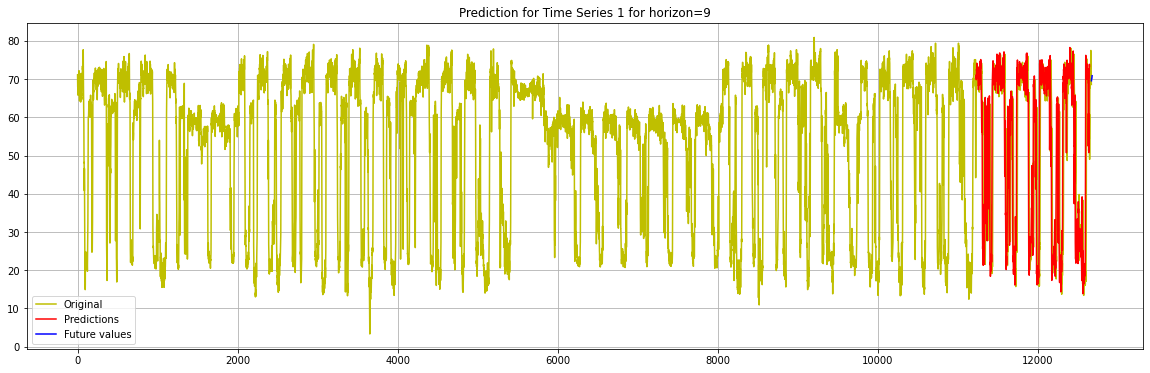

In [114]:
plot_predictions(time_df['TS1'], x, true_predictions_TS1, future_predictions_TS1, "Time Series 1")

In [115]:
len(future_predictions_TS2)

9

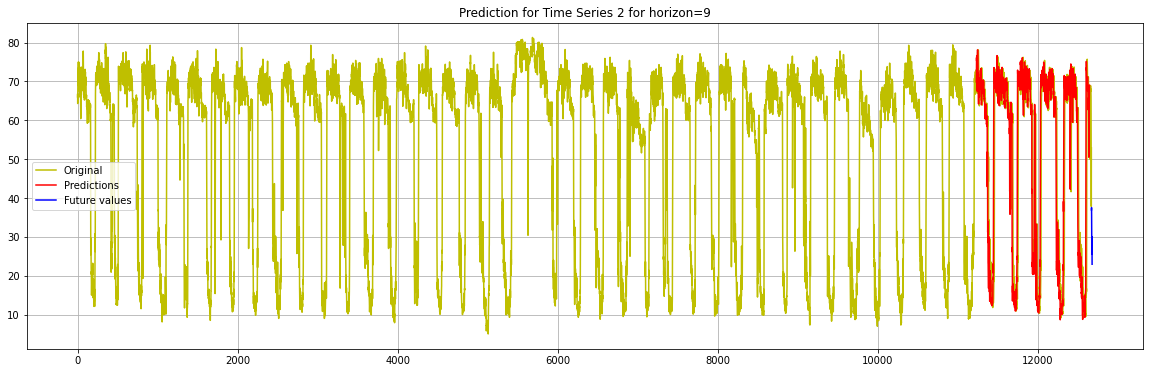

In [116]:
plot_predictions(time_df['TS2'], x, true_predictions_TS2, future_predictions_TS2, "Time Series 2")

### 2. Predict 9 values in the test set

In [117]:
#Predict 9 future values of test set and compute RMSE loss for it.
def predict(X_test, y_test, number):
    preds = X_test.tolist()
    targets = torch.FloatTensor(y_test)
    
    model.eval()
    with torch.no_grad():
        for i in range(future):         
            seq = torch.FloatTensor(preds[-window_size:])
            seq = seq.view(1,len(seq),-1)
            hidden = model.hidden_state(test_batchSize)
            y_pred = model(seq,hidden)

            loss = criterion(y_pred, targets[i])
            
            preds.append(y_pred)

        print(f"RMSE loss for time series-{number} is {loss.item()}")
        return preds

In [118]:
preds_TS1 = predict(X_test_TS1[0], y_test_TS1[0:future], 1)
preds_TS2 = predict(X_test_TS2[0], y_test_TS2[0:future], 2)

RMSE loss for time series-1 is 0.025324005633592606
RMSE loss for time series-2 is 0.06615300476551056


In [119]:
true_predictions_TS1 = scaler.inverse_transform(np.array(preds_TS1[-future:]).reshape(-1, 1))
true_predictions_TS2 = scaler.inverse_transform(np.array(preds_TS2[-future:]).reshape(-1, 1))

In [120]:
x = np.arange(11232,11232+future)
x

array([11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239, 11240])

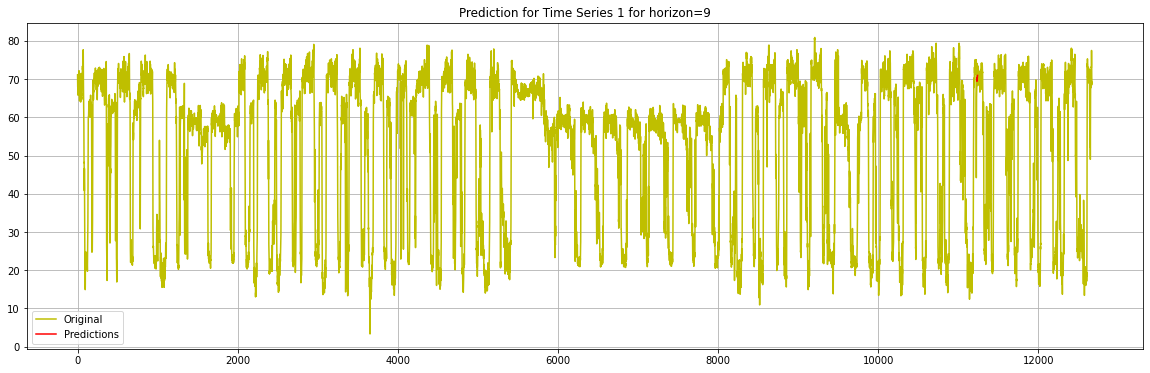

In [121]:
plot_predictions(time_df['TS1'], x, true_predictions_TS1, [], "Time Series 1")

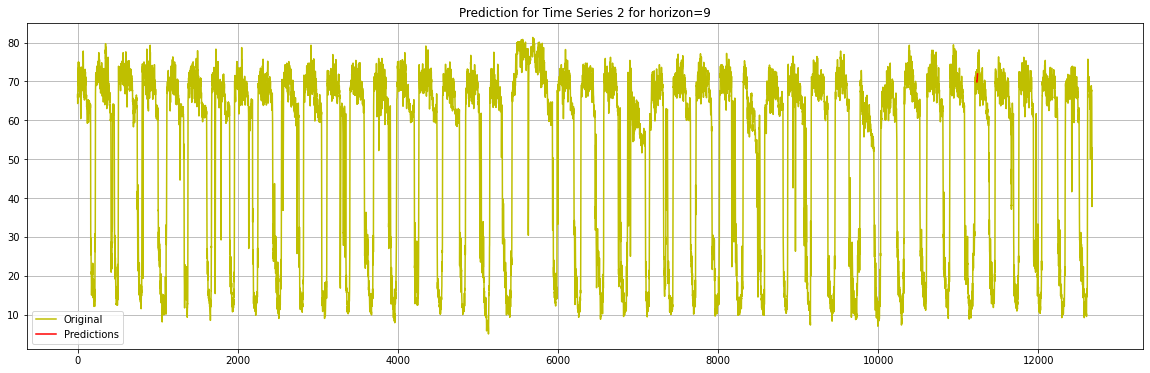

In [122]:
plot_predictions(time_df['TS2'], x, true_predictions_TS2, [], "Time Series 2")